<a href="https://colab.research.google.com/github/Seunsoipe/NLP-Complaints-Checkpoint/blob/main/NLP_Complaints_Checkpoint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer

from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
import nltk
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup
import string
from wordcloud import WordCloud
from sklearn.metrics import confusion_matrix



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from keras.preprocessing.sequence import pad_sequences

In [ ]:
!pip install wordcloud 

# Data 

In [ ]:
data = pd.read_csv('complaints-2023-01-24_04_51.csv', engine='python', encoding='utf-8', error_bad_lines=False, sep=',')

In [ ]:
data.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,04/27/20,Mortgage,Home equity loan or line of credit (HELOC),Trouble during payment process,None,NaN,None,TD BANK US HOLDING COMPANY,NY,12077,None,NaN,Referral,04/27/20,Closed with explanation,Yes,NaN,3625761
1,03/23/20,Debt collection,I do not know,Written notification about debt,Didn't receive enough information to verify debt,NaN,None,ERC,LA,70722,None,Consent not provided,Web,03/23/20,Closed with explanation,Yes,NaN,3576463
2,05/19/20,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Account information incorrect,NaN,None,"EQUIFAX, INC.",NJ,07036,None,Consent not provided,Web,05/19/20,Closed with explanation,Yes,NaN,3658230
3,02/04/20,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Their investigation did not fix an error on yo...,NaN,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,CA,91343,None,Consent not provided,Web,02/04/20,Closed with explanation,Yes,NaN,3519636
4,02/18/20,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Their investigation did not fix an error on yo...,NaN,None,"EQUIFAX, INC.",FL,34639,None,Consent not provided,Web,02/19/20,Closed with explanation,Yes,NaN,3536173


In [ ]:
data = data[["Product","Consumer complaint narrative"]]

In [ ]:
data.head()

,Product,Consumer complaint narrative
0,Mortgage,NaN
1,Debt collection,NaN
2,"Credit reporting, credit repair services, or o...",NaN
3,"Credit reporting, credit repair services, or o...",NaN
4,"Credit reporting, credit repair services, or o...",NaN


In [ ]:
data.Product.value_counts()

Credit reporting, credit repair services, or other personal consumer reports    89407
Debt collection                                                                 20875
Credit card or prepaid card                                                     13454
Mortgage                                                                         9909
Checking or savings account                                                      9173
Money transfer, virtual currency, or money service                               2583
Vehicle loan or lease                                                            2510
Student loan                                                                     2366
Payday loan, title loan, or personal loan                                        1850
Name: Product, dtype: int64

In [ ]:
data.isnull().sum()

Product                             0
Consumer complaint narrative    85198
dtype: int64

In [ ]:
data.dropna(axis = 0, inplace = True)

In [ ]:
data.isnull().sum()

Product                         0
Consumer complaint narrative    0
dtype: int64

<AxesSubplot:>

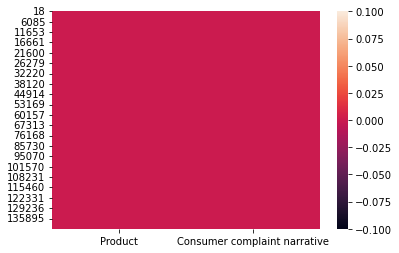

In [ ]:
sns.heatmap(data.isnull())

# Preprocessing & Vizz

In [ ]:
# We will group some product types 
data.loc[data['Product'] == 'Credit reporting', 'Product'] = 'Credit reporting, credit repair services, or other personal consumer reports'
data.loc[data['Product'] == 'Credit card', 'Product'] = 'Credit card or prepaid card'
data.loc[data['Product'] == 'Payday loan', 'Product'] = 'Payday loan, title loan, or personal loan'
data.loc[data['Product'] == 'Virtual currency', 'Product'] = 'Money transfer, virtual currency, or money service'


In [ ]:
# In the code below you should add : Prepaid card, Consumer Loan & Bank account or service to "Other financial service"

# CODE HERE

data.loc[data['Product'] == 'Prepaid card', 'Product'] = 'Other financial service'
data.loc[data['Product'] == 'Consumer Loan', 'Product'] = 'Other financial service'
data.loc[data['Product'] == 'Bank account', 'Product'] = 'Other financial service'

# We will not consider other financial service
# Code Here
data = data[data.Product != 'Other financial service']


In [ ]:
data = data.reset_index(drop=True)

In [ ]:
data

,Product,Consumer complaint narrative
0,"Credit reporting, credit repair services, or o...",REMOVE THE ATTACHED FTC VIOLATIONS
1,"Payday loan, title loan, or personal loan",One month ago I contacted green sky requesting...
2,"Credit reporting, credit repair services, or o...",I decided to get my credit pulled due to a bil...
3,Checking or savings account,OK SO I WAS XXXX BACK IN XX/XX/XXXX TO BE EXA...
4,Mortgage,Why didn't the assigned SPOC ever call or get ...
...,...,...
66924,Debt collection,Someone used my identity and I have tried to c...
66925,"Credit reporting, credit repair services, or o...","On XXXX, XXXX, and XXXX, I have paid {$1000.00..."
66926,"Credit reporting, credit repair services, or o...",I am a XXXX year old woman who is continuously...
66927,Mortgage,I am attempting to work with my mortgage compa...


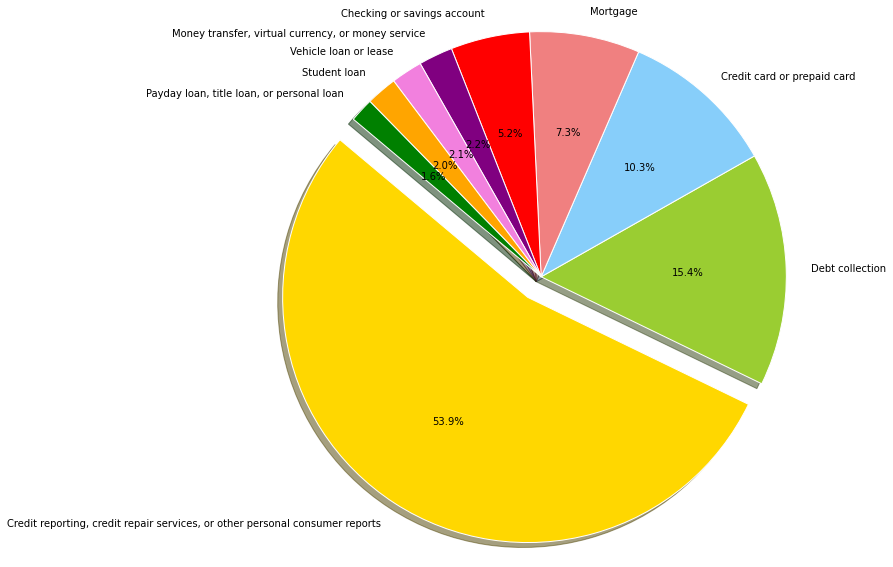

In [ ]:
# Data to plot
labels = list(data.Product.value_counts().index)
sizes = list(data.Product.value_counts().values)
colors = ['gold','yellowgreen', 'lightskyblue', 'lightcoral', 'red', 'purple', '#f280de', 'orange', 'green']
explode = (0.1, 0, 0, 0,0,0,0,0,0)  # explode 1st slice

# Plot
plt.figure(figsize=(10,10))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140, wedgeprops={"edgecolor":"white"})
plt.axis('equal')
plt.show()

In [ ]:
def complaint_product(indx,data):
  complaint = data['Consumer complaint narrative'][indx]
  product = data['Product'][indx]
  print(complaint)
  print('------------------------------')
  print("Product : ",product)

In [ ]:
complaint_product(1238, data)

This account does not belong to me and is being reported on my account. I want to have it removed.
------------------------------
Product :  Credit reporting, credit repair services, or other personal consumer reports


In [ ]:
complaint_product(3238, data)

Hello, My name is XXXX XXXX. My fianc just recently purposed to me. We are ecstatic, and ready to start out dream wedding. 
Upon review of my credit report, there are an ample amount of Accounts, Collections, and inquiries that do not pertain to me and I are results of identity theft. Please remove these item as they our affecting my credit worthiness. 
Please remove these item from my report or legal action will be taken. 
Thanking you in advance.
------------------------------
Product :  Credit reporting, credit repair services, or other personal consumer reports


In [ ]:
complaint_product(11238, data)

XXXX  is inaccurately reporting that I was 60 and 90 days late in XX/XX/XXXX, XX/XX/XXXX, and in XX/XX/XXXX for XXXX XXXX. 

XXXX  is inaccurately reporting that I was 30, 60 and 90 days late in XX/XX/XXXX, XX/XX/XXXX, and in XX/XX/XXXX, XX/XX/XXXX XXXX XXXX. 

Transunion is inaccurately reporting that I was 30, 60 and 90 days late in XX/XX/XXXX, XX/XX/XXXX, and in XX/XX/XXXX, XX/XX/XXXX XXXX XXXX.
------------------------------
Product :  Credit reporting, credit repair services, or other personal consumer reports


In [ ]:
complaint_product(20000, data)

Experian refuses to unlock my credit report using their feature called " XXXX ''. I have tried multiple times and it is an error each time. This flaw in their system has in turn sabotaged my ability to get a XXXX loan through the XXXX for my failing business. I can not unlock my Experian File due to their system malfunctioning and in turn it can be the life or death of my business.
------------------------------
Product :  Credit reporting, credit repair services, or other personal consumer reports


In [ ]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation, remove words containing numbers, remove stop words and Xs.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('\n', '', text)
    text = text.replace('x', '')
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    return text

In [ ]:
# Code Here
# data['Consumer complaint narrative'] = clean_text(str['Consumer complaint narrative']) # apply clean_text function

for i in data.loc[:, 'Consumer complaint narrative'].index:
    data.loc[i, 'Consumer complaint narrative'] = clean_text(data.loc[i, 'Consumer complaint narrative'])

In [ ]:
data.head()

,Product,Consumer complaint narrative
0,"Credit reporting, credit repair services, or o...",remove attached ftc violations
1,"Payday loan, title loan, or personal loan",one month ago contacted green sky requesting d...
2,"Credit reporting, credit repair services, or o...",decided get credit pulled due bill received ma...
3,Checking or savings account,ok back eact make story short got basically sp...
4,Mortgage,didnt assigned spoc ever call get back emailed...


In [ ]:
data

,Product,Consumer complaint narrative
0,"Credit reporting, credit repair services, or o...",remove attached ftc violations
1,"Payday loan, title loan, or personal loan",one month ago contacted green sky requesting d...
2,"Credit reporting, credit repair services, or o...",decided get credit pulled due bill received ma...
3,Checking or savings account,ok back eact make story short got basically sp...
4,Mortgage,didnt assigned spoc ever call get back emailed...
...,...,...
66924,Debt collection,someone used identity tried contact company he...
66925,"Credit reporting, credit repair services, or o...",paid toward cc mastercard owed card balance ba...
66926,"Credit reporting, credit repair services, or o...",year old woman continuously badgered refuses d...
66927,Mortgage,attempting work mortgage company guild mortgag...


In [ ]:
# After cleaning
complaint_product(238, data)

made numerous phone calls letter credit bureaus eperian reporting non data information credit bureaus listed dates event information erroneous outdated eperiencing amount due current status home loan denied credit due non data information credit report dates supposedly representing payments time ok status credit important working diligently towards situation requesting eperian please work together correcting issue
------------------------------
Product :  Credit reporting, credit repair services, or other personal consumer reports


In [ ]:
complaint_product(1238, data)

account belong reported account want removed
------------------------------
Product :  Credit reporting, credit repair services, or other personal consumer reports


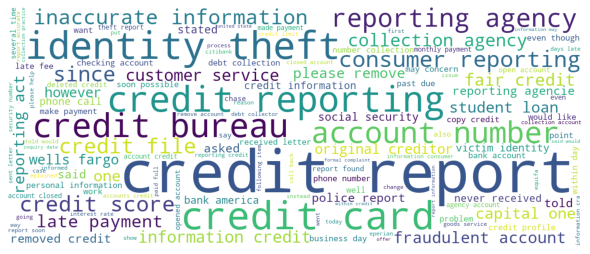

In [ ]:
text = " ".join(complaint for complaint in data["Consumer complaint narrative"])
# Generate a word cloud image

wordcloud = WordCloud(width = 1200, height = 500, 
                background_color ='white', 
                stopwords = STOPWORDS, 
                min_font_size = 10).generate(text) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [ ]:
number_words = [len(complaints.split(' ')) for complaints in data["Consumer complaint narrative"]]

In [ ]:
#number_words

In [ ]:
num_df = pd.DataFrame(number_words)

num_df.value_counts().sort_values(ascending = False)

35      1132
32       923
36       857
20       851
28       834
        ... 
1249       1
1250       1
1251       1
1252       1
777        1
Length: 901, dtype: int64

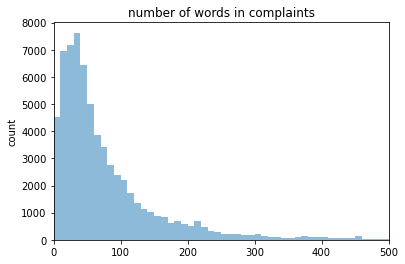

In [ ]:
# fixed bin size
bins = np.arange(-0, 3000, 10) # fixed bin size

plt.xlim([0, 500])

plt.hist(number_words, bins=bins, alpha=0.5)
plt.title('number of words in complaints')
plt.ylabel('count')

plt.show()

<AxesSubplot:>

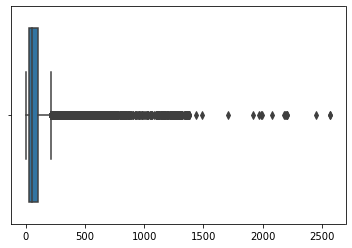

In [ ]:
sns.boxplot(number_words)

# Multi-Class Text Classification LSTM 

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
# data['Consumer complaint narrative'].values

In [ ]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(data['Consumer complaint narrative'].values) #on an array
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 43921 unique tokens.


In [ ]:
X = tokenizer.texts_to_sequences(data['Consumer complaint narrative'].values)#list of integers
print(X)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH) #padding
print('Shape of data tensor:', X.shape)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Shape of data tensor: (66929, 250)


In [ ]:
labels = list(pd.get_dummies(data['Product']).columns)
Y = pd.get_dummies(data['Product']).values
print('Shape of label tensor:', Y.shape)
print(Y[:5])

Shape of label tensor: (66929, 9)
[[0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0]
 [0 0 1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0]]


In [ ]:
labels

['Checking or savings account',
 'Credit card or prepaid card',
 'Credit reporting, credit repair services, or other personal consumer reports',
 'Debt collection',
 'Money transfer, virtual currency, or money service',
 'Mortgage',
 'Payday loan, title loan, or personal loan',
 'Student loan',
 'Vehicle loan or lease']

In [ ]:
# Code Here
X_train, X_test, Y_train, Y_test =  train_test_split(X, Y, test_size = 0.3)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(46850, 250) (46850, 9)
(20079, 250) (20079, 9)


**Expected Output :**
(35449, 250) (35449, 9)
(8863, 250) (8863, 9)

In [ ]:
# Code Here
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=250))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(9, activation='softmax'))
model.compile(loss= 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 100)          5000000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 250, 100)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 9)                 909       
                                                                 
Total params: 5,081,309
Trainable params: 5,081,309
Non-trainable params: 0
_________________________________________________________________
None


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param   
_________________________________________________________________
embedding_1 (Embedding)      (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 250, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 909    
_________________________________________________________________

Total params: 5,081,309
Trainable params: 5,081,309
Non-trainable params: 0


In [ ]:
epochs = 5
batch_size = 64
# Code Here
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5
659/659 [==============================] - 830s 1s/step - loss: 0.9842 - accuracy: 0.6782 - val_loss: 0.6919 - val_accuracy: 0.7851
Epoch 2/5
659/659 [==============================] - 728s 1s/step - loss: 0.6509 - accuracy: 0.7954 - val_loss: 0.5821 - val_accuracy: 0.8105
Epoch 3/5
659/659 [==============================] - 639s 969ms/step - loss: 0.5418 - accuracy: 0.8279 - val_loss: 0.5901 - val_accuracy: 0.8145
Epoch 4/5
659/659 [==============================] - 777s 1s/step - loss: 0.4989 - accuracy: 0.8421 - val_loss: 0.6727 - val_accuracy: 0.7866
Epoch 5/5
659/659 [==============================] - 847s 1s/step - loss: 0.4316 - accuracy: 0.8649 - val_loss: 0.5374 - val_accuracy: 0.8290


In [ ]:
# evaluate model on test set
# Code Here
score = model.evaluate(X_test, Y_test)
print('Test set\n  Loss: {:0.2f}\n  Accuracy: {:0.2f}'.format(score[0],score[1]))

628/628 [==============================] - 87s 138ms/step - loss: 0.5804 - accuracy: 0.8166
Test set
  Loss: 0.58
  Accuracy: 0.82


Test set

  Loss: 0.66
  
  Accuracy: 0.80

In [ ]:
Y_pred = model.predict(X_test)

628/628 [==============================] - 76s 116ms/step


In [ ]:
predicted_classes = np.argmax(Y_pred, axis=1)

In [ ]:
predicted_classes

array([2, 2, 2, ..., 6, 2, 3], dtype=int64)

In [ ]:
# Code Here
expected_classes = np.argmax(Y_test, axis =1)

In [ ]:
expected_classes

array([2, 2, 2, ..., 4, 3, 3], dtype=int64)

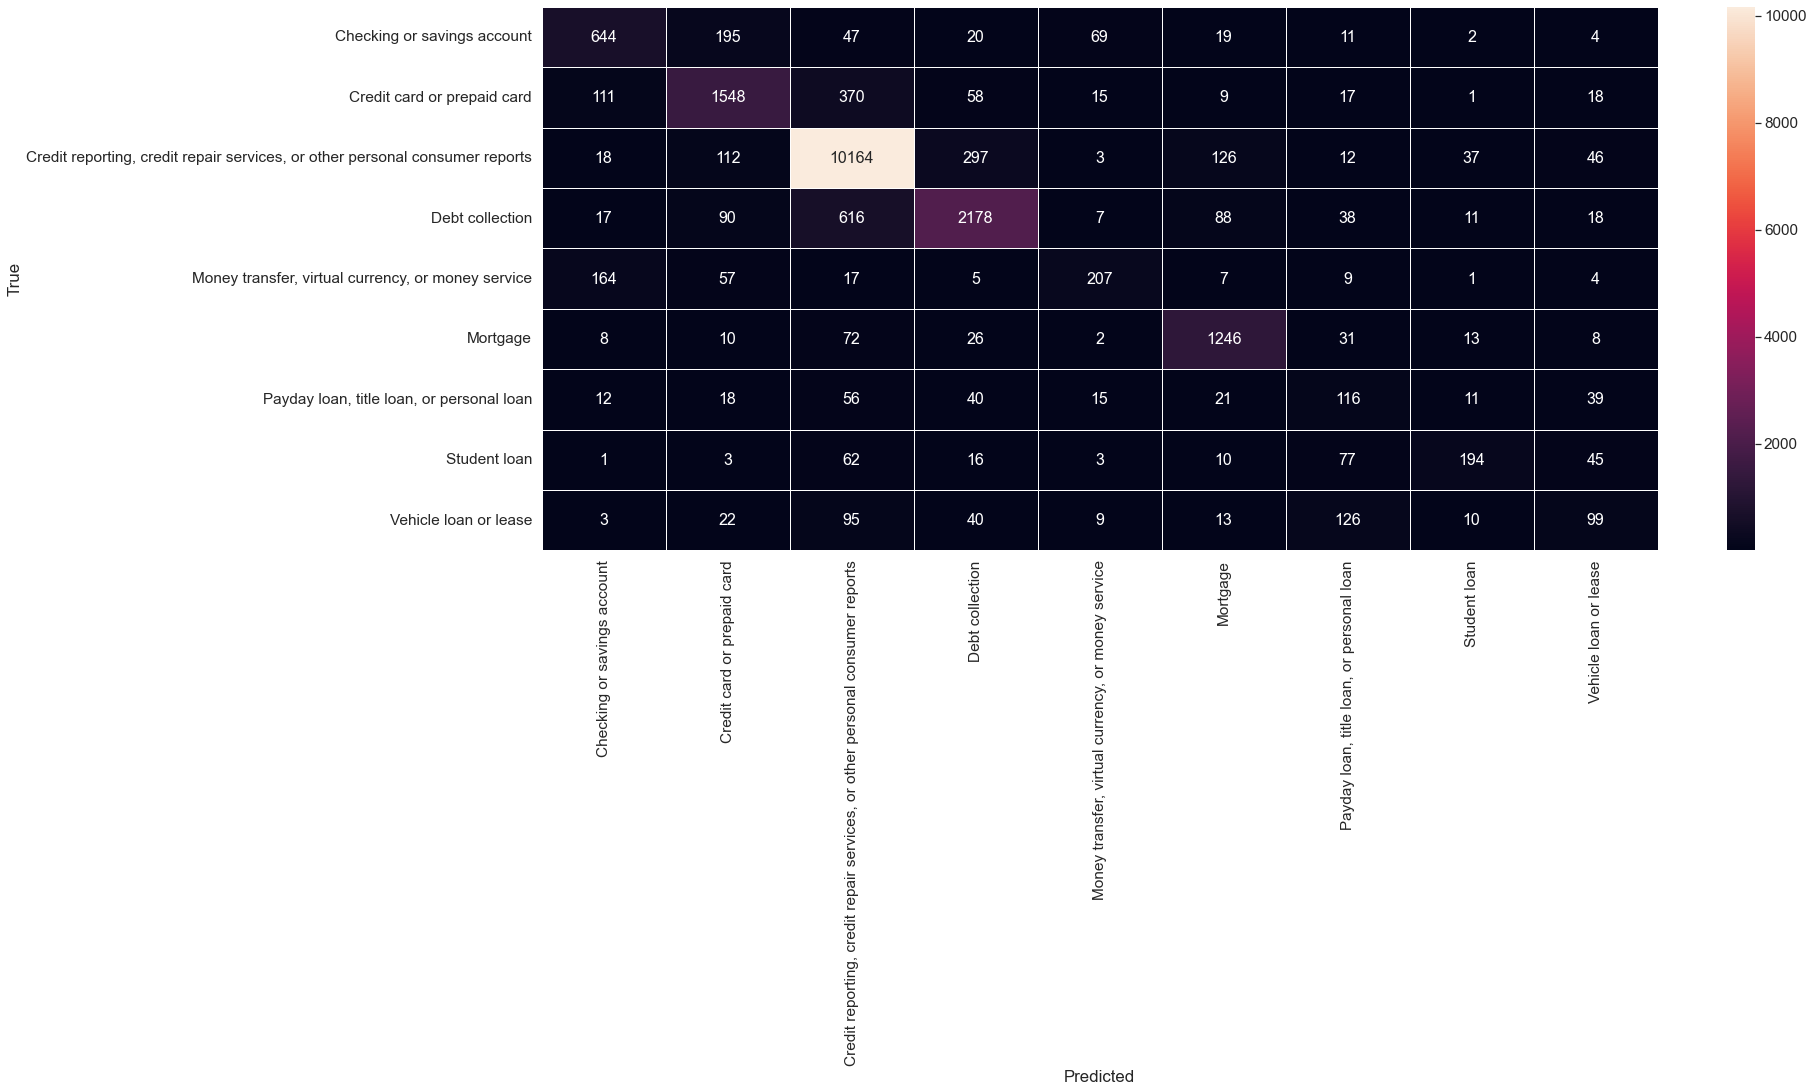

In [ ]:

cm = confusion_matrix(expected_classes, predicted_classes)
plt.figure(figsize=(25,10))
sns.set(font_scale=1.4) 
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, fmt='d',linewidths=0.5, xticklabels=labels, yticklabels=labels) 
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()